In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

from matplotlib.ticker import MaxNLocator, FormatStrFormatter

PLOT_STYLE = "proton.mplstyle"

plt.style.use(PLOT_STYLE)



In [4]:
# Replace 'filename.csv' with your actual file name or file path
df = pd.read_csv('../results/noisy_aer_simulations_random_seeds_raw.csv')
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

In [5]:
df_300 = df[df['argparse.label'] == 300]
df_030 = df[df['argparse.label'] == 30]

# Sort both dataframes by group_col to ensure alignment within groups
df_300_sorted = df_300.sort_values(['lambda_noise']).reset_index(drop=True)
df_030_sorted = df_030.sort_values(['lambda_noise']).reset_index(drop=True)

offset = -258.9475070402643 + 259.2063702444815
#offset = 0
energy_diff = df_030_sorted['expectation_value'] - df_300_sorted['expectation_value'] - offset

df_diff = pd.DataFrame()
df_diff['expectation_value'] = energy_diff
df_diff['lambda_noise'] = df_300_sorted['lambda_noise']

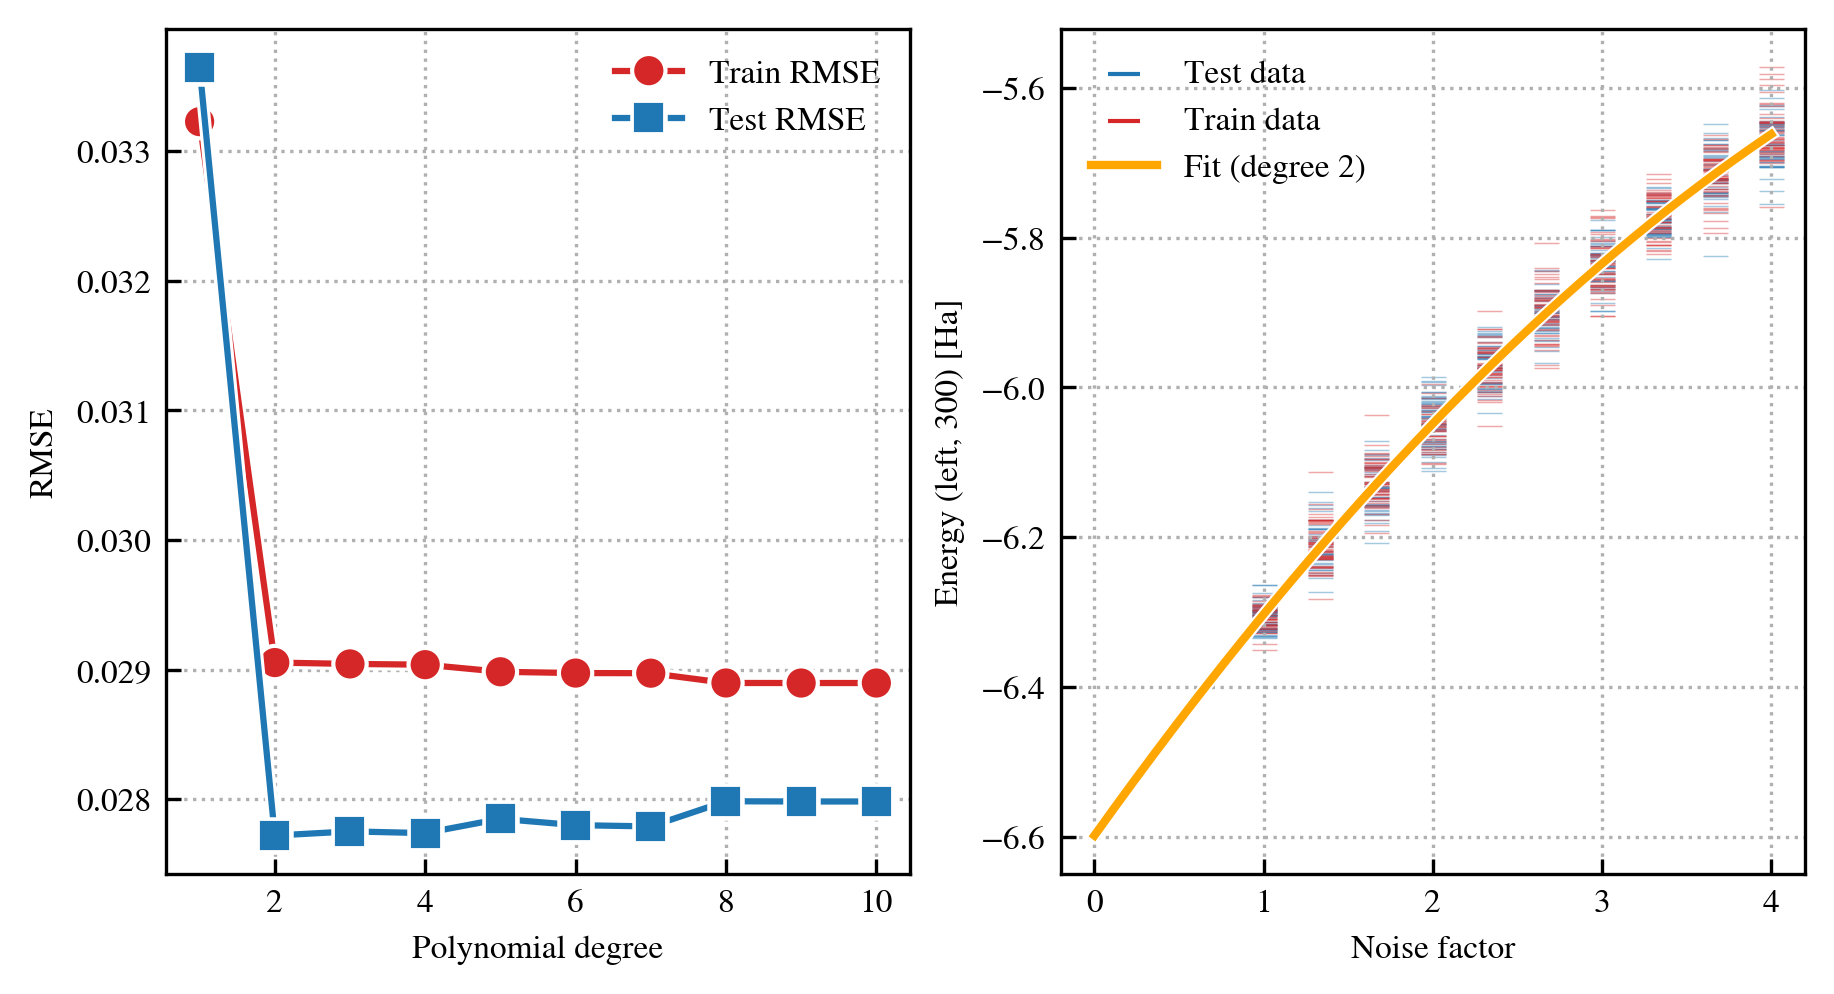

In [36]:
import matplotlib.patheffects as mpe

pe1 = [mpe.Stroke(linewidth=3, foreground='white'),
           mpe.Stroke(foreground='white', alpha=1),
           mpe.Normal()]

df = df_300
X = df[['lambda_noise']].values  # Make sure X is 2D
y = df['expectation_value'].values

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

degrees = range(1, 11)
train_rmse, test_rmse = [], []
train_mae, test_mae = [], []
train_r2, test_r2 = [], []

for d in degrees:
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    train_rmse.append(root_mean_squared_error(y_train, y_train_pred))
    test_rmse.append(root_mean_squared_error(y_test, y_test_pred))
    train_mae.append(mean_absolute_error(y_train, y_train_pred))
    test_mae.append(mean_absolute_error(y_test, y_test_pred))
    train_r2.append(r2_score(y_train, y_train_pred))
    test_r2.append(r2_score(y_test, y_test_pred))

# Best model (lowest test RMSE)
best_degree = degrees[np.argmin(test_rmse)]
poly_best = PolynomialFeatures(degree=best_degree)
X_train_poly_best = poly_best.fit_transform(X_train)
X_test_poly_best = poly_best.transform(X_test)
model_best = LinearRegression()
model_best.fit(X_train_poly_best, y_train)
x_curve = np.linspace(0, X.max(), 200).reshape(-1, 1)
x_curve_poly = poly_best.transform(x_curve)
y_curve = model_best.predict(x_curve_poly)

# Set up subplots
fig, axs = plt.subplots(1, 2, figsize=(6.0, 3.2), constrained_layout=True)
palette = ["#003f5c", "#bc5090", "#ffa600"]


# (1) RMSE vs Degree
axs[0].grid(True, ls=":")
axs[0].plot(degrees, train_rmse, marker='o', label="Train RMSE", color="tab:red", path_effects=pe1)
axs[0].plot(degrees, test_rmse, marker='s', label="Test RMSE", color="tab:blue", path_effects=pe1)
axs[0].set_xlabel("Polynomial degree")
axs[0].set_ylabel("RMSE")
axs[0].legend(fontsize="medium")
"""
# (2) MAE vs Degree
axs[1].plot(degrees, train_mae, marker='o', label="Train MAE")
axs[1].plot(degrees, test_mae, marker='s', label="Test MAE")
axs[1].set_xlabel("Polynomial Degree")
axs[1].set_ylabel("MAE")
axs[1].set_title("MAE vs Polynomial Degree")
axs[1].legend()
axs[1].grid(True)

# (3) R^2 vs Degree
axs[2].plot(degrees, train_r2, marker='o', label="Train $R^2$")
axs[2].plot(degrees, test_r2, marker='s', label="Test $R^2$")
axs[2].set_xlabel("Polynomial Degree")
axs[2].set_ylabel("$R^2$ Score")
axs[2].set_title("$R^2$ Score vs Polynomial Degree")
axs[2].legend()
axs[2].grid(True)
"""
# (4) Best Polynomial Fit
axs[1].grid(True, ls=":")

axs[1].scatter(X_test, y_test, alpha=0.4, label='Test data', color="tab:blue",
    linewidth=0.35,
    marker='_',)
axs[1].scatter(X_train, y_train, alpha=0.4, label='Train data', color="tab:red",
    linewidth=0.35,
    marker='_',)

axs[1].plot(x_curve, y_curve, color=palette[2], lw=2, path_effects=pe1,
               label=f'Fit (degree {best_degree})')
axs[1].set_xlabel("Noise factor")
axs[1].set_ylabel("Energy (left, 300) [Ha]")
#axs[3].set_title(
#    f"Best Polynomial Fit (degree={best_degree})\nTest RMSE: {test_rmse[best_degree-1]:.2f}, Test MAE: {test_mae[best_degree-1]:.2f}, Test $R^2$: {test_r2[best_degree-1]:.2f}"
#)
lgnd = axs[1].legend(fontsize="medium")
lgnd.legend_handles[0]._sizes = [60]
lgnd.legend_handles[1]._sizes = [60]
lgnd.legend_handles[0]._linewidths = [1]
lgnd.legend_handles[1]._linewidths = [1]
lgnd.legend_handles[0]._alpha = [1]
lgnd.legend_handles[1]._alpha = [1]
plt.savefig("polynomialfit_300.pdf")

Fitted coefficients:
c (intercept): -6.322613172848597

95% confidence interval for intercept (c):
Lower bound: -6.3353
Upper bound: -6.3099


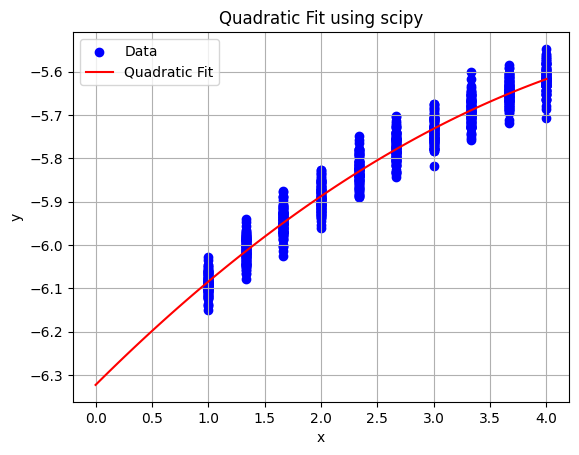

In [7]:

df = df_030
# Example data
x = df['lambda_noise']
y = df['expectation_value']

# Define the quadratic model
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

def linear(x, b, c):
    return b * x + c


# Perform the curve fit
#popt, pcov = curve_fit(quadratic, x, y)
popt, pcov = curve_fit(quadratic, x, y)

_, _, c = popt

# Print fitted coefficients
print('Fitted coefficients:')
#print(f'a (x^2): {a}')
#print(f'b (x): {b}')
print(f'c (intercept): {c}')

# Calculate standard errors and 95% confidence intervals
perr = np.sqrt(np.diag(pcov))
from scipy.stats import t

# Degrees of freedom
dof = max(0, len(x) - len(popt))
# 95% confidence interval (two-sided), use t-distribution for small samples
tval = t.ppf(1-0.025, dof) if dof > 0 else 1.96

c_lower = c - tval * perr[2]
c_upper = c + tval * perr[2]

print('\n95% confidence interval for intercept (c):')
print(f'Lower bound: {c_lower:.4f}')
print(f'Upper bound: {c_upper:.4f}')

# Prepare curve for plotting
x_fit = np.linspace(0, x.max(), 100)
y_fit = quadratic(x_fit, *popt)

# Plot data and fit
plt.scatter(x, y, color='blue', label='Data')
plt.plot(x_fit, y_fit, color='red', label='Quadratic Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Quadratic Fit using scipy')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def get_bootstrap_coefficients(df, n_boot=1000, seed=42, quadratic=True):
    x_obs = df['lambda_noise'].values
    y_obs = df['expectation_value'].values
    unique_x = np.unique(x_obs)
    indices_by_x = {xi: np.where(x_obs == xi)[0] for xi in unique_x}
    n_reps = len(indices_by_x[unique_x[0]])
    coefs = []

    rng = np.random.default_rng(seed=seed)
    for _ in range(n_boot):
        x_sample = []
        y_sample = []
        for xi in unique_x:
            idxs = indices_by_x[xi]
            chosen = rng.choice(idxs, size=n_reps, replace=True)
            x_sample.extend([xi] * n_reps)
            y_sample.extend(y_obs[chosen])
        x_sample = np.array(x_sample)
        y_sample = np.array(y_sample)
        try:
            if quadratic:
                popt, _ = curve_fit(lambda x, a, b, c: a*x**2 + b*x + c, x_sample, y_sample)
            else:
                popt, _ = curve_fit(lambda x, b, c: b*x + c, x_sample, y_sample)
            coefs.append(popt)
        except RuntimeError:
            continue
    return np.array(coefs)

def scatter_with_boot_lines(df, coefs, title, color, quadratic=True):
    x_obs = df['lambda_noise'].values
    y_obs = df['expectation_value'].values
    x_line = np.linspace(0, x_obs.max(), 200)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(x_obs, y_obs, color='black', s=20, alpha=0.1, label='Observed data')

    # To avoid overplotting, randomly sample up to 500 lines
    idx = np.random.choice(len(coefs), min(500, len(coefs)), replace=False)
    for i in idx:
        if quadratic:
            a, b, c = coefs[i]
            y_line = a * x_line**2 + b * x_line + c
        else:
            b, c = coefs[i]
            y_line = b * x_line + c
        ax.plot(x_line, y_line, color=color, alpha=0.1, linewidth=1)
    ax.set_xlabel('lambda_noise')
    ax.set_ylabel('expectation_value')
    ax.set_title(title)
    plt.grid(True)
    plt.show()

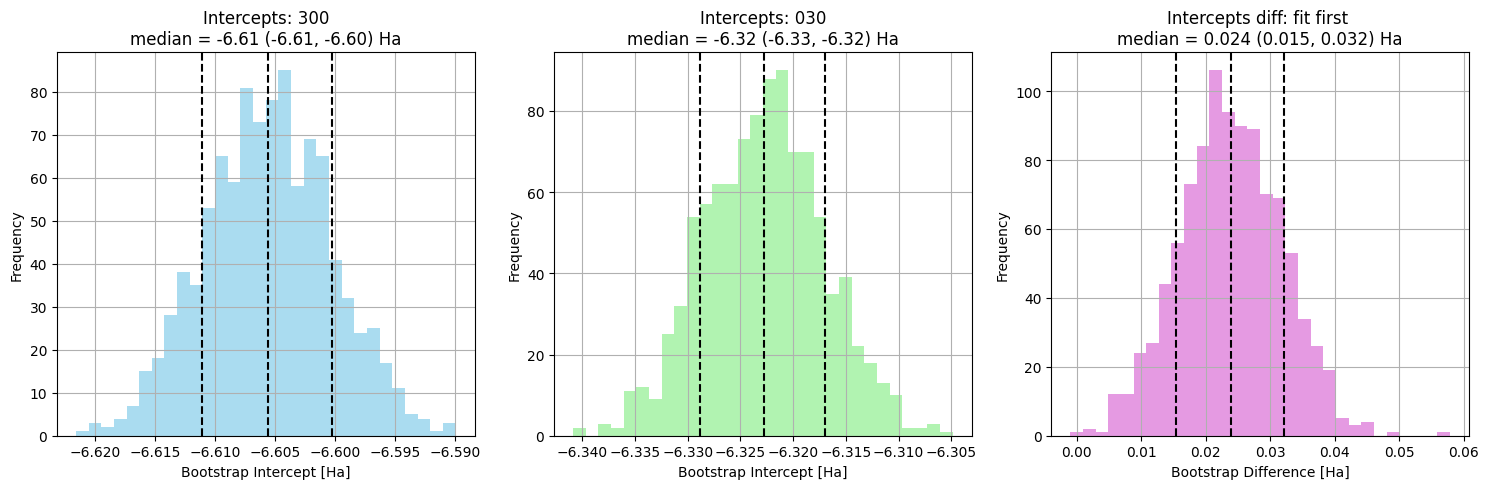

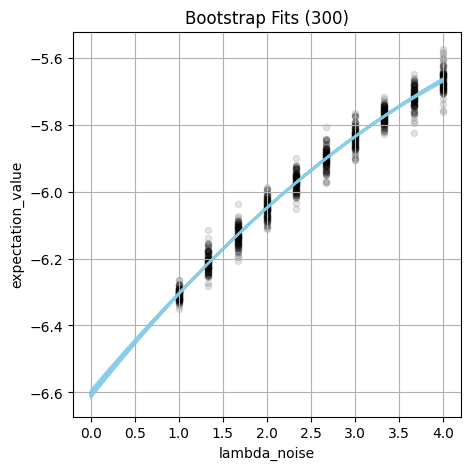

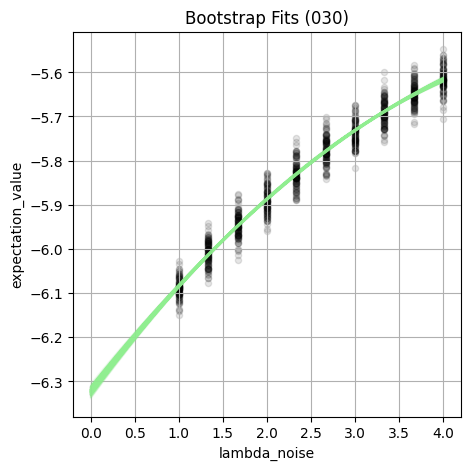

In [9]:
n_boot = 1000
coefs_300 = get_bootstrap_coefficients(df_300, n_boot=n_boot, seed=42)
coefs_030 = get_bootstrap_coefficients(df_030, n_boot=n_boot, seed=123)

intercepts_300 = coefs_300[:, 2]
intercepts_030 = coefs_030[:, 2]
deltas = intercepts_030 - intercepts_300 - offset

#mean_300, median_300, low_300, high_300 = np.mean(intercepts_300), np.mean(intercepts_300), np.percentile(intercepts_300, 2.5), np.percentile(intercepts_300, 97.5)
#mean_030, median_030, low_030, high_030 = np.mean(intercepts_030), np.mean(intercepts_030), np.percentile(intercepts_030, 2.5), np.percentile(intercepts_030, 97.5)
#mean_d, median_d, low_d, high_d = np.mean(deltas), np.mean(deltas), np.percentile(deltas, 2.5), np.percentile(deltas, 97.5)
mean_300, median_300, low_300, high_300 = np.mean(intercepts_300), np.mean(intercepts_300), np.percentile(intercepts_300, 15), np.percentile(intercepts_300, 85)
mean_030, median_030, low_030, high_030 = np.mean(intercepts_030), np.mean(intercepts_030), np.percentile(intercepts_030, 15), np.percentile(intercepts_030, 85)
mean_d, median_d, low_d, high_d = np.mean(deltas), np.mean(deltas), np.percentile(deltas, 15), np.percentile(deltas, 85)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(intercepts_300, bins=30, alpha=0.7, color='skyblue')
axes[0].axvline(low_300, color='black', linestyle='--', label='15th percentile')
axes[0].axvline(high_300, color='black', linestyle='--', label='85th percentile')
axes[0].axvline(median_300, color='black', linestyle='--', label='median')
axes[0].set_xlabel('Bootstrap Intercept [Ha]')
axes[0].set_ylabel('Frequency')
axes[0].set_title(
    f'Intercepts: 300\nmedian = {median_300:.2f} ({low_300:.2f}, {high_300:.2f}) Ha'
)
#axes[0].legend()
axes[0].grid(True)

axes[1].hist(intercepts_030, bins=30, alpha=0.7, color='lightgreen')
axes[1].axvline(low_030, color='black', linestyle='--', label='15th percentile')
axes[1].axvline(high_030, color='black', linestyle='--', label='85th percentile')
axes[1].axvline(median_030, color='black', linestyle='--', label='median')
axes[1].set_xlabel('Bootstrap Intercept [Ha]')
axes[1].set_ylabel('Frequency')
axes[1].set_title(
    f'Intercepts: 030\nmedian = {median_030:.2f} ({low_030:.2f}, {high_030:.2f}) Ha'
)
#axes[1].legend()
axes[1].grid(True)

axes[2].hist(deltas, bins=30, alpha=0.7, color='orchid')
axes[2].axvline(low_d, color='black', linestyle='--', label='15th percentile')
axes[2].axvline(high_d, color='black', linestyle='--', label='85th percentile')
axes[2].axvline(median_d, color='black', linestyle='--', label='median')
axes[2].set_xlabel('Bootstrap Difference [Ha]')
axes[2].set_ylabel('Frequency')
axes[2].set_title(
    f'Intercepts diff: fit first \nmedian = {median_d:.3f} ({low_d:.3f}, {high_d:.3f}) Ha'
)
#axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

plt.show()
# Now plot scatter + fitted lines for each dataset
scatter_with_boot_lines(df_300, coefs_300, "Bootstrap Fits (300)", 'skyblue')
scatter_with_boot_lines(df_030, coefs_030, "Bootstrap Fits (030)", 'lightgreen')

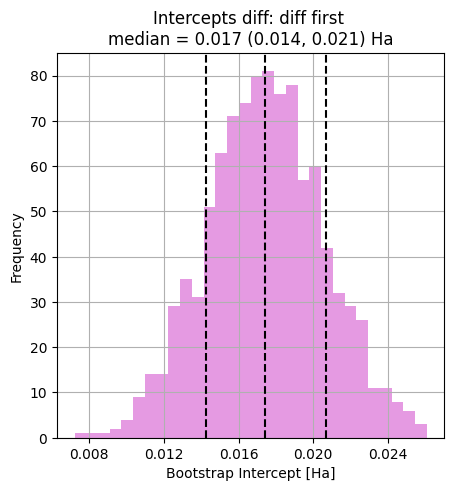

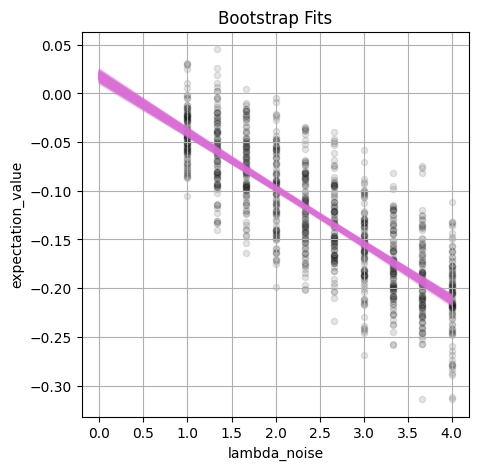

In [10]:
quadratic_bool = False
coefs_diff = get_bootstrap_coefficients(df_diff, n_boot=n_boot, seed=42, quadratic=quadratic_bool)
if quadratic_bool:
    intercepts_diff = coefs_diff[:, 2]
else:
    intercepts_diff = coefs_diff[:, 1]
        
#mean_diff, median_diff, low_diff, high_diff = np.mean(intercepts_diff), np.mean(intercepts_diff), np.percentile(intercepts_diff, 2.5), np.percentile(intercepts_diff, 97.5)
mean_diff, median_diff, low_diff, high_diff = np.mean(intercepts_diff), np.mean(intercepts_diff), np.percentile(intercepts_diff, 15), np.percentile(intercepts_diff, 85)

# Plot histograms with enhanced titles
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.hist(intercepts_diff, bins=30, alpha=0.7, color='orchid')
axes.axvline(low_diff, color='black', linestyle='--', label='2.5th percentile')
axes.axvline(high_diff, color='black', linestyle='--', label='97.5th percentile')
axes.axvline(median_diff, color='black', linestyle='--', label='median')
axes.set_xlabel('Bootstrap Intercept [Ha]')
axes.set_ylabel('Frequency')
axes.set_title(
    f'Intercepts diff: diff first \nmedian = {median_diff:.3f} ({low_diff:.3f}, {high_diff:.3f}) Ha'
)
#axes.legend()
# Set fewer and nicely formatted x-ticks
axes.xaxis.set_major_locator(MaxNLocator(nbins=6))  # e.g., 6 major ticks
axes.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # three decimal digits

axes.grid(True)

scatter_with_boot_lines(df_diff, coefs_diff, "Bootstrap Fits", 'orchid', quadratic=quadratic_bool)


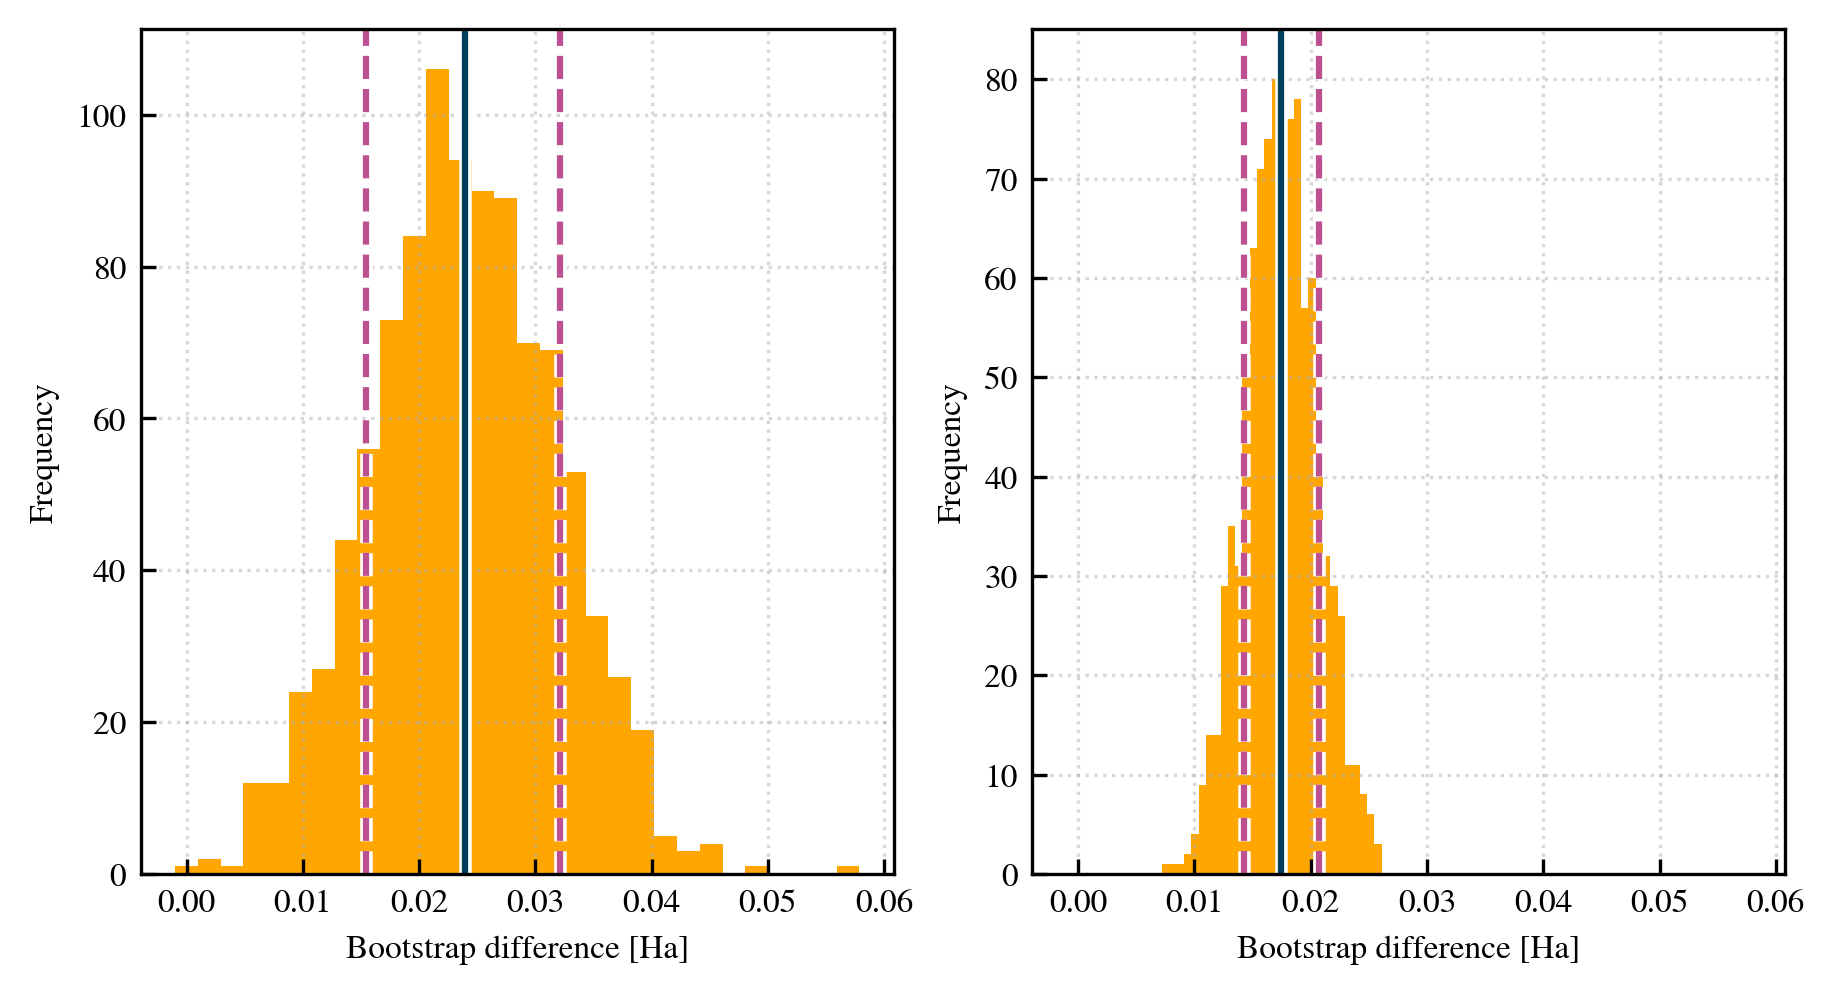

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(6.0, 3.2), constrained_layout=True, sharex=True)
palette = ["#003f5c", "#bc5090", "#ffa600"]
axes[1].grid(True, linestyle=":", alpha=0.5)
axes[0].grid(True, linestyle=":", alpha=0.5)

axes[0].hist(deltas, bins=30, alpha=1, ec="none", color=palette[2])
axes[0].axvline(low_d, color=palette[1], linestyle='--', label=r'15$^{\rm th}$ percentile', 
                path_effects=pe1)
axes[0].axvline(high_d, color=palette[1], linestyle='--', label=r'85$^{\rm th}$ percentile', 
                path_effects=pe1)
axes[0].axvline(median_d, color=palette[0], linestyle='-', label='Median', path_effects=pe1)
#axes[0].set_xlabel('Bootstrap Difference [Ha]')
axes[0].set_ylabel('Frequency')


axes[1].hist(intercepts_diff, bins=30, alpha=1, ec="none", color=palette[2])
axes[1].axvline(low_diff, color=palette[1], linestyle='--', label=r'15$^{\rm th}$ percentile', 
                path_effects=pe1)
axes[1].axvline(high_diff, color=palette[1], linestyle='--', label=r'85$^{\rm th}$ percentile', 
                path_effects=pe1)
axes[1].axvline(median_diff, color=palette[0], linestyle='-', label='Median', path_effects=pe1)
axes[0].set_xlabel('Bootstrap difference [Ha]')
axes[1].set_xlabel('Bootstrap difference [Ha]')
axes[1].set_ylabel('Frequency')

plt.savefig("bootstrap_intercepts.pdf")
plt.show()

In [12]:
deltas.shape

(1000,)